In [62]:
import config
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from operator import attrgetter
import datetime as dt
import seaborn as sns
import scipy.optimize
import numpy.typing as npt

In [63]:
def date_to_milliseconds(date: dt.datetime) -> float:
    return date.timestamp() * 1000

def milliseconds_to_date(milliseconds: float) -> dt.datetime:
    return dt.datetime.fromtimestamp(milliseconds / 1000)

def months_to_milliseconds(months: float) -> float:
    return months * config.MILLISECONDS_IN_MONTH

def milliseconds_to_months(milliseconds: float) -> float:
    return milliseconds / config.MILLISECONDS_IN_MONTH

def ceil_round(x: float, /, *, multiple: float) -> float:
    '''
    Raises
    ------
    ValueError: If `multiple` is zero.
    '''
    if multiple == 0:
        raise ValueError('Argument `multiple` must be non-zero.')
    
    return np.ceil(x / multiple) * multiple

def inclusive_range(start: float, end: float, step: float) -> npt.NDArray[np.float64]:
    '''
    Generate a numpy array representing a range of values from 'start' to 'end', inclusive, with a specified 'step' size. The resulting array includes the 'end' value but may go over 'end' if necessary to ensure inclusion based on the 'step' size.

    Raises
    ------
    ValueError: If `start` is greater than `end` is zero.
    ValueError: If `step` is zero.
    '''

    if start > end:
        raise ValueError('Argument `start` cannot be greater than argument `end`.')

    if step <= 0:
        raise ValueError('Argument `step` must be strictly greater than zero.')

    size = np.ceil((end - start) / step) + 1
    inclusive_range_arr = start + step * np.arange(size)
    return inclusive_range_arr

In [64]:
def quarter_to_timestamp_milliseconds(quarter_str: str) -> float:
    quarter_index, year = map(int, quarter_str[1:].split())
    month = quarter_index * 3 - 2
    date = dt.datetime(year, month, 1)
    return date_to_milliseconds(date)

observed = pd.read_csv(config.DATA_DIR / 'facebook_quarterly_monthly_active_users.csv')
observed['timestamp_milliseconds'] = observed['quarter'].apply(quarter_to_timestamp_milliseconds)

In [65]:
def forward_euler(theta, *, t_start, t_end, t_step):
    S0, I0, R0, alpha, beta = theta
    N = S0 + I0 + R0

    t_start_offset = 0
    t_end_offset = t_end - t_start
    t = inclusive_range(t_start_offset, t_end_offset, t_step)
    size = len(t)

    S = np.zeros(size)
    I = np.zeros(size)
    S[0] = S0
    I[0] = I0

    for n, _ in enumerate(t[:-1]):
        S[n + 1] = S[n] + t_step * (-alpha / N * S[n] * I[n])
        I[n + 1] = I[n] + t_step * (alpha / N * S[n] * I[n] - beta * I[n])

    t += t_start
    model = pd.DataFrame({
        'I': I,
        'timestamp_milliseconds': t,
    })
    return model

def forward_euler_milliseconds(theta, *, t_start_months, t_end_months, t_step_months):
    model_months = forward_euler(theta, t_start=t_start_months, t_end=t_end_months, t_step=t_step_months)
    model_milliseconds = model_months.rename(columns={'t': 'timestamp_milliseconds'})
    model_milliseconds['timestamp_milliseconds'] = model_milliseconds['timestamp_milliseconds'].apply(months_to_milliseconds)
    return model_milliseconds

def least_squares_criterion(theta) -> float:
    I_data = observed['MAU']
    t = observed['timestamp_milliseconds']

    time_options = {
        't_start_months': milliseconds_to_months(np.min(t)),
        't_end_months': milliseconds_to_months(np.max(t)),
        't_step_months': 1e-1,
    }
    I_estimate = forward_euler_milliseconds(theta, **time_options)
    
    I_interpolated = np.interp(t, I_estimate['timestamp_milliseconds'], I_estimate['I'])

    # TODO: dit checken
    # return np.sum((I_data - I_interpolated) ** 2)
    return np.sum(np.abs(I_data - I_interpolated))

In [69]:
EPSILON = np.finfo(float).eps
theta_intuitive = attrgetter('S0', 'I0', 'R0', 'alpha', 'beta')(config.FACEBOOK_SIR_CONSTANTS)

# TODO: check dat de som = N
worldwide_internet_users_count = config.FACEBOOK_SIR_CONSTANTS.N
theta_bounds = scipy.optimize.Bounds(lb=(0, 0, 0, EPSILON, EPSILON), ub=(worldwide_internet_users_count, worldwide_internet_users_count, worldwide_internet_users_count, np.inf, np.inf))
# FIXME: CHECKEN
# theta_bounds = None
theta_guess = theta_intuitive
# FIXME: LOKALE MINIMA :(
# theta_guess = (1.56658545e+09, 1.93600000e+09, 8.35877372e+08, 3.07889702e-02, 3.17417354e-04)
# theta_guess = (8999.999989328582 * 1e6, 2091.3725329982294 * 1e6, 391.5967421761192 * 1e6, 0.0229549598647329, 0.011219988332903545)
result: scipy.optimize.OptimizeResult = scipy.optimize.minimize(fun=least_squares_criterion, x0=theta_guess, method='nelder-mead', bounds=theta_bounds, options={
    # TODO: explain choices xatol and fatol
    # 'xatol': min(1, 1e-6),
    # 'fatol': 1e-5,
    'xatol': min(1, 1e-5),
    'fatol': 1e4,
    # 'xatol': np.inf,
    # 'fatol': np.inf,
    # 'fatol': 25 * (1e5 / 25) ** 2,
    # 'xatol': 1e15,
    # 'fatol': 0.4e9,
    # 'maxiter': 1e5,
    # 'maxfev': 1e5,
    'maxiter': np.inf,
    'maxfev': np.inf,
    'disp': True,
})

theta_optimized = result.x

print(f'{result.success=}')
print(f'{result.status=}')
print(f'{result.message=}')
print(f'{result.nit=}')
print(f'{result.nfev=}')
print(f'{theta_optimized=}')

Optimization terminated successfully.
         Current function value: 781025416.149457
         Iterations: 1562
         Function evaluations: 2664
result.success=True
result.status=0
result.message='Optimization terminated successfully.'
result.nit=1562
result.nfev=2664
theta_optimized=array([2.45390748e+09, 1.93600000e+09, 5.46500768e+08, 2.84173155e-02,
       2.83179503e-03])


In [67]:
time_options = {
    't_start_months': milliseconds_to_months(np.min(observed['timestamp_milliseconds'])),
    't_end_months': milliseconds_to_months(np.max(observed['timestamp_milliseconds'])),
    't_step_months': 1e-1,
}
model_intuitive = forward_euler_milliseconds(theta_intuitive, **time_options)
model_optimized = forward_euler_milliseconds(theta_optimized, **time_options)

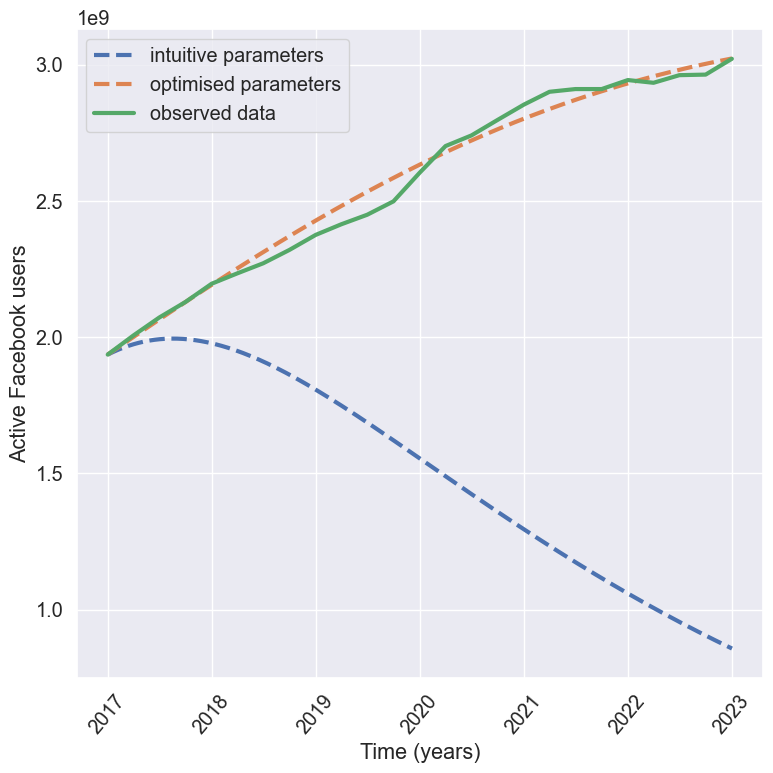

In [68]:
FIGURE_WIDTH = 8
FIGURE_HEIGHT = 8
LINEWIDTH = 3
FONT_SCALE = 1.3

MODEL_LINESTYLE = 'dashed'
OBSERVED_LINESTYLE = 'solid'

sns.set_theme()
sns.set(font_scale=FONT_SCALE)
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

sns.lineplot(data=model_intuitive, x='timestamp_milliseconds', y='I', label='intuitive parameters', linewidth=LINEWIDTH, linestyle=MODEL_LINESTYLE)
sns.lineplot(data=model_optimized, x='timestamp_milliseconds', y='I', label='optimised parameters', linewidth=LINEWIDTH, linestyle=MODEL_LINESTYLE)
sns.lineplot(data=observed, x='timestamp_milliseconds', y='MAU', label='observed data', linewidth=LINEWIDTH, linestyle=OBSERVED_LINESTYLE)

def timestamp_milliseconds_to_year(timestamp_milliseconds: float) -> int:
    date = milliseconds_to_date(timestamp_milliseconds)
    return date.year

def year_to_timestamp_milliseconds(year: int) -> float:
    date = dt.datetime(year, 1, 1)
    return date_to_milliseconds(date)

all_timestamps_milliseconds = np.concatenate([
    model_intuitive['timestamp_milliseconds'], 
    model_optimized['timestamp_milliseconds'], 
    observed['timestamp_milliseconds'],
])
min_year = timestamp_milliseconds_to_year(np.min(all_timestamps_milliseconds))
max_year = timestamp_milliseconds_to_year(np.max(all_timestamps_milliseconds))
years = np.arange(min_year, max_year + 1) # FIXME: CHECK OF 2017 - 2023 IS
xticks = list(map(year_to_timestamp_milliseconds, years)) # FIXME: CHECK OF WEGHALEN LIST NIET ERG IS
xlabels = years

ax = plt.gca()
ax.set_xticks(xticks, xlabels, rotation=50)

plt.xlabel('Time (years)')
plt.ylabel('Active Facebook users')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'basic_facebook_sir_model_parameter_optimization.svg')
plt.show()